In [196]:
# Created on Sun Aug 13 13:14:06 2023

# @author: katelynsmith

import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "Times New Roman"
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
#plt.style.use(['no-latex']) 
#from emcee import MASER
import glob
import os 
import pandas as pd

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import LombScargle

import scipy.signal as sps

import maser as ms
import starspot as ss
import astrobase as ab
#from astrobase import periodbase


from tqdm import tqdm 
# Setting directory

ddir = '/Users/katelynsmith/Desktop/Capstone/'

import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import curve_fit

In [2]:
# Defining variables 

M_s = 0.5 # Star mass (solar masses) #### REFERENCE (PAPER 6 on one note) #####
R_s = 0.75 # Star radius (solar radii) ####  REFERENCE (PAPER 6 on one note) ####
P_s = 4.86 # Star rotation period (days) ####  REFERENCE (PAPER 6 on one note) ####
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) ####  ACCORDING TO MEETING WITH BEN ####
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) #### https://arxiv.org/pdf/2304.09642.pdf #### 
beta = 20 # Star magnetic obliquity (degrees) #### ACCORDING TO MEETING WITH BEN ####
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1) <<<<<< LEFT AS IS
a = 10 # Planet orbital distance (stellar radii) #### REFERENCE (PAPER 6 on one note) ####
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees) #### REFERENCE (PAPER 7 on one note) #### 
lam = 0 # Planet projected spin-orbit angle (degrees) #### ranging from -15 to 18 degrees 
#REFERENCE Spin-orbit alignment and magnetic activity in the young planetary system AU Mic⋆ ####
P_p = 8.4630351 # AU Mic b period in days
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) <<<<< LEFT AS IS
f = 10 # Emission observing frequency (MHz) #### - MAY INCREASE TO 3 GHz REFERENCE (PAPER 6 on one note) ####
alpha = 75 # Emission cone opening angle (degrees) <<<<< LEFT THESE AS IS - BASED ON KAVANAGH 2023
dalpha = 5 # Emission cone thickness (degrees) <<<<< LEFT THESE AS IS - BASED ON KAVANAGH 2023

In [3]:
def get_events(t, vis):
    ups = np.where(np.diff(vis,1) > 0)[0]+1
    downs = np.where(np.diff(vis,1) < 0)[0]

    if ups[0] > downs[0]:
        downs = np.delete(downs,0)
    elif ups[-1] > downs [-1]:
        ups = np.delete(ups,-1)
    
    full_length = np.min([len(ups),len(downs)])
    ups, downs = ups[:full_length], downs[:full_length]

    durations = t[downs] - t[ups]
    centres = t[ups] + durations/2

    return centres, durations

In [4]:
def group_events(central_points):
    durations = np.diff(central_points)
    central_points = central_points[:-1] + durations/2

    return durations, central_points

In [63]:
times = np.linspace(0, 1820, 40000) # Array of observation times to compute (days) - running for 5 years

# Call the function

visibility_North, visibility_South = ms.maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0


In [64]:
ind_centres_S, ind_durations_S = get_events(times, visibility_South)
g_centres_S, g_durations_S = group_events(ind_centres_S)
minima_S = np.where(np.abs(g_centres_S - np.min(g_centres_S)) < 0.01)[0]
true_durations_S, timings_S = group_events(minima_S)

xs = g_durations_S 
ys = (g_centres_S/g_centres_S.max())

ind_centres_N, ind_durations_N = get_events(times, visibility_North)
g_centres_N, g_durations_N = group_events(ind_centres_N)
minima_N = np.where(np.abs(g_centres_N - np.min(g_centres_N)) < 0.01)[0]
true_durations_N, timings_N = group_events(minima_N)

xn = g_durations_N 
yn = (g_centres_N/g_centres_N.max())

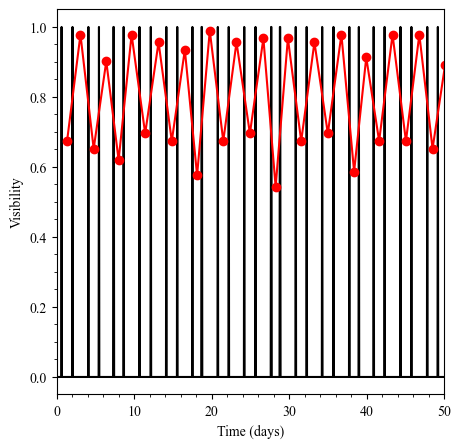

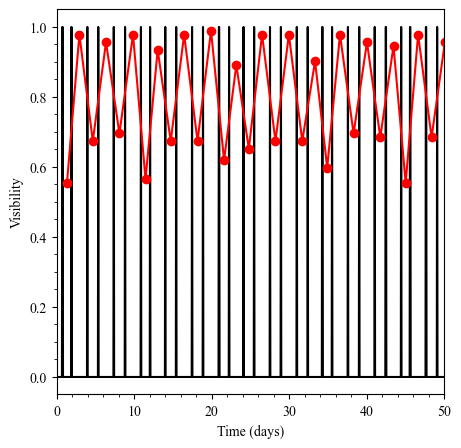

In [69]:
fig = plt.figure(figsize=(5, 5))
plt.plot(times, visibility_South, 'k')
plt.plot(xs,ys, 'ro-')
plt.xlabel('Time (days)')
plt.ylabel('Visibility')
plt.xlim(0,50)
plt.minorticks_on()
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.plot(times, visibility_North, 'k')
plt.plot(xn,yn, 'ro-')
plt.xlim(0,50)
plt.xlabel('Time (days)')
plt.ylabel('Visibility')
plt.minorticks_on()
plt.show()

In [66]:
lower_curve_N = [yn[i] for i in range(0, len(yn),2)]
lower_times_N = [xn[i] for i in range(0, len(xn),2)]

lower_curve_S = [ys[i] for i in range(0, len(ys),2)]
lower_times_S = [xs[i] for i in range(0, len(xs),2)]

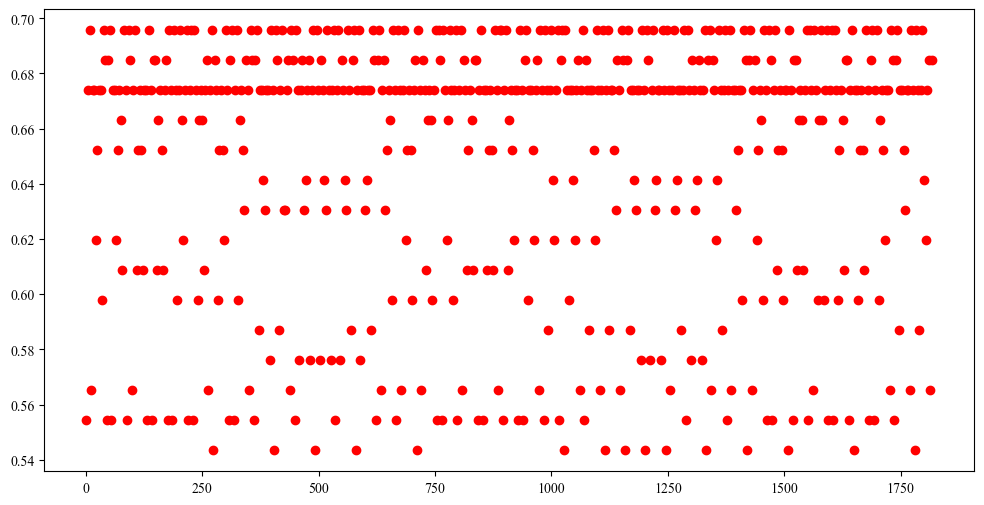

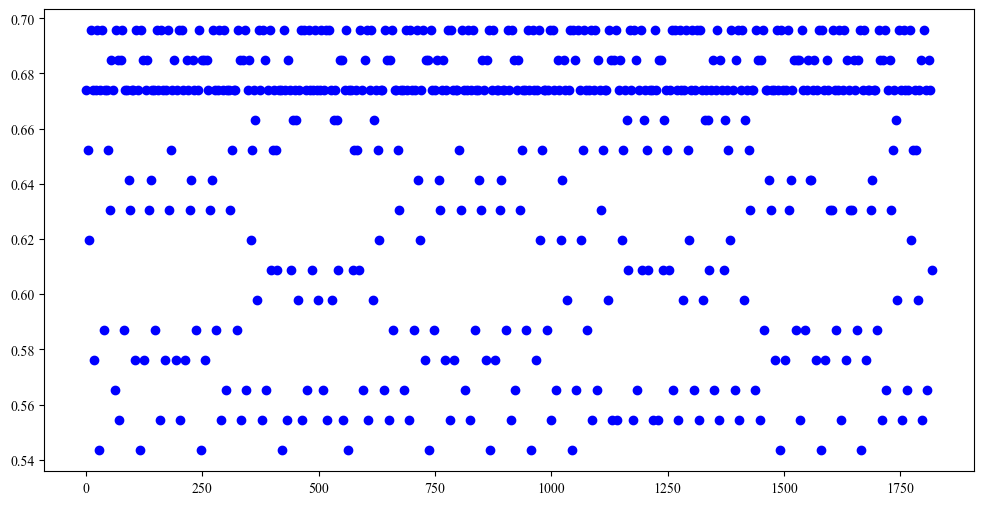

In [160]:
# plotting the lower curves for the northern and southern hemispheres

fig = plt.figure(figsize=(12, 6))
plt.plot(lower_times_N, lower_curve_N, 'ro')
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.plot(lower_times_S, lower_curve_S, 'bo')
plt.show()


In [80]:
# calculating the mean spacings of the points

mean_spacing_S = np.mean(np.diff(lower_times_S))
mean_spacing_N = np.mean(np.diff(lower_times_N))



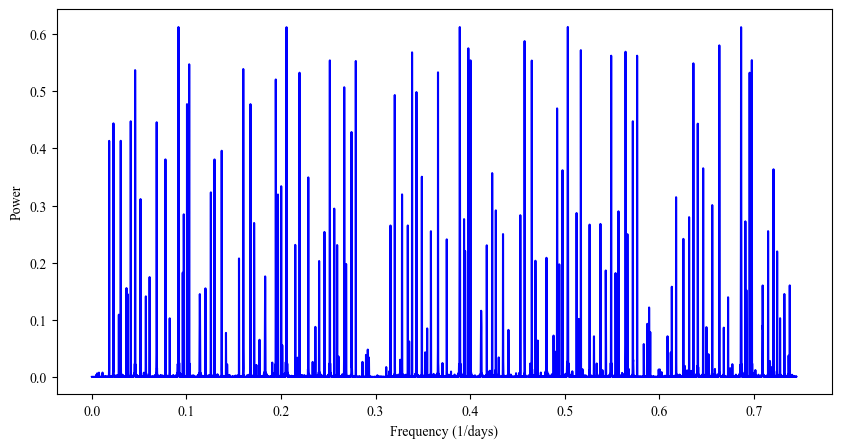

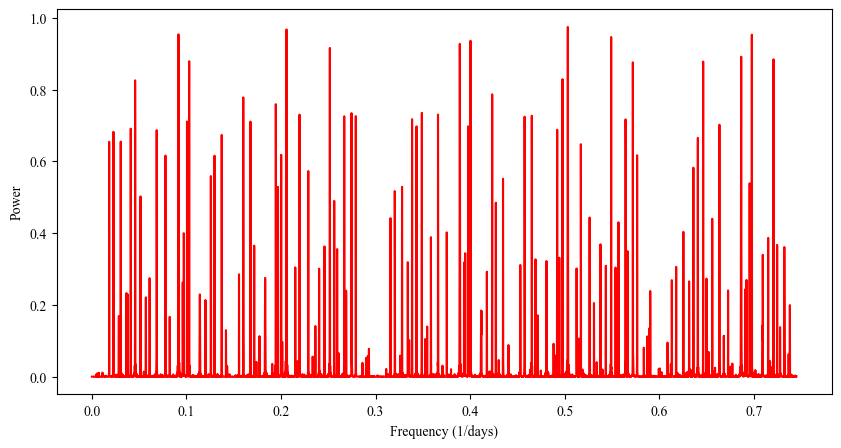

In [173]:
frequency_N, power_N = LombScargle(lower_times_N, lower_curve_N, nterms=5, normalization='psd').autopower()


fig = plt.figure(figsize=(10, 5))
plt.plot(frequency_N, power_N, 'b')
plt.xlabel('Frequency (1/days)')
plt.ylabel('Power')
plt.show()


frequency_S, power_S = LombScargle(lower_times_S, lower_curve_S, nterms=5).autopower()

fig = plt.figure(figsize=(10, 5))
plt.plot(frequency_S, power_S, 'r')
plt.xlabel('Frequency (1/days)')
plt.ylabel('Power')
plt.show()

# they are perfectly overlapped



In [219]:
sorted_f_N = np.sort(frequency_N)
reverse_f_N= sorted_f_N[::-1]

A1_N = reverse_f_N[0]
A2_N = reverse_f_N[1]
A3_N = reverse_f_N[2]

ratio1_N = A2_N/A1_N
ratio2_N = A3_N/A1_N

print(ratio1_N)
print(ratio2_N)

sorted_f_S = np.sort(frequency_S)
reverse_f_S= sorted_f_S[::-1]

A1_S = reverse_f_S[0]
A2_S = reverse_f_S[1]
A3_S = reverse_f_S[2]

ratio1_S = A2_S/A1_S
ratio2_S = A3_S/A1_S

print(ratio1_S)
print(ratio2_S)

# sum of ratios

sum_ratios_N = ratio1_N + ratio2_N
sum_ratios_S = ratio1_S + ratio2_S

0.9998521256931608
0.9997042513863216
0.9998521256931608
0.9997042513863217


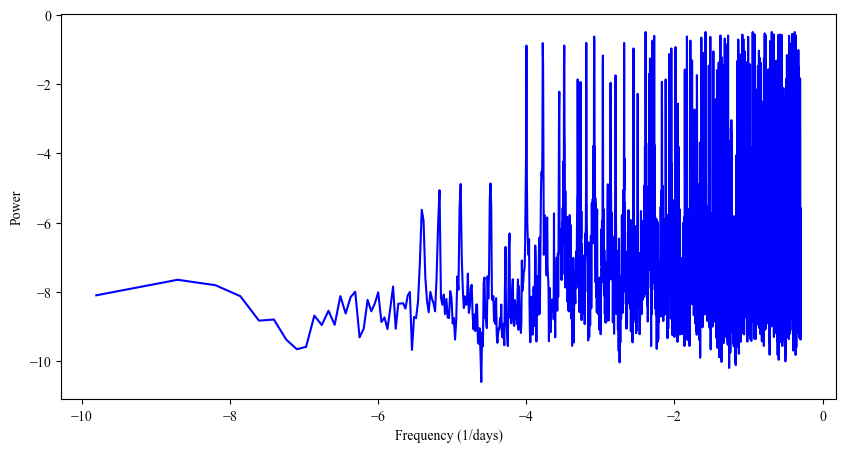

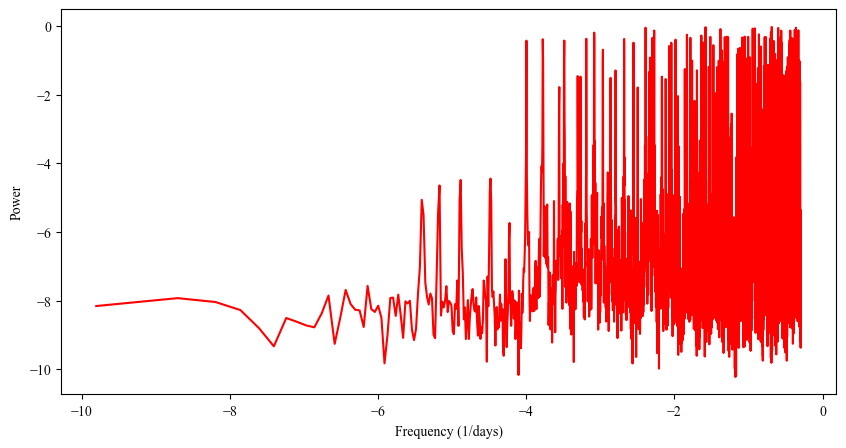

In [176]:
fig = plt.figure(figsize=(10, 5))
plt.plot(np.log(frequency_N), np.log(power_N), 'b')
plt.xlabel('Frequency (1/days)')
plt.ylabel('Power')
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.plot(np.log(frequency_S), np.log(power_S), 'r')
plt.xlabel('Frequency (1/days)')
plt.ylabel('Power')
plt.show()

In [195]:
best_frequency_N = frequency_N[np.argmax(power_N)]
best_frequency_S = frequency_S[np.argmax(power_S)]

best_period_N = 1/best_frequency_N
best_period_S = 1/best_frequency_S


t_fit = np.linspace(0, 1)

ls_N = LombScargle(lower_times_N, lower_curve_N, nterms=5)
y_fit_N = ls_N.model(t_fit, best_frequency_N)

ls_S = LombScargle(lower_times_S, lower_curve_S, nterms=5)
y_fit_S = ls_S.model(t_fit, best_frequency_S)



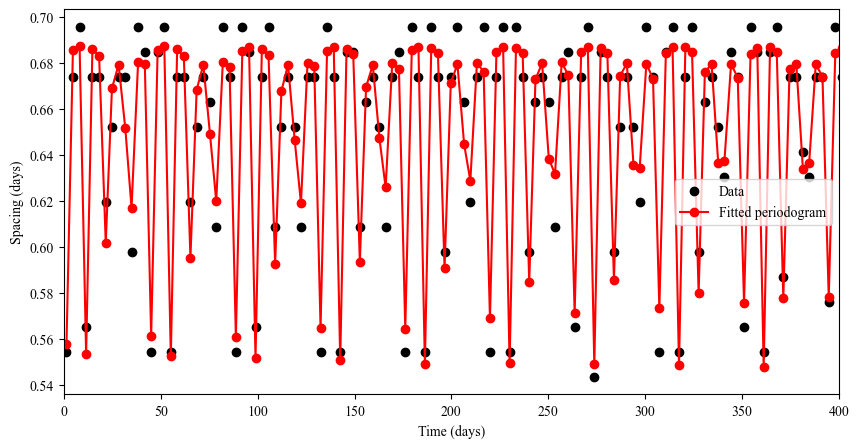

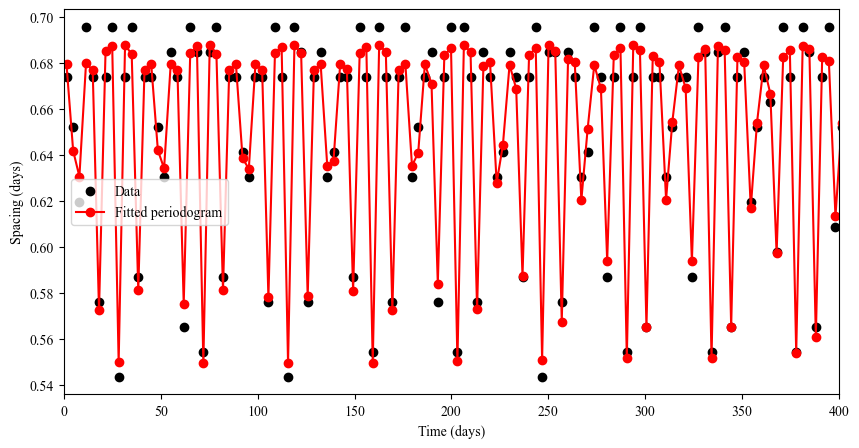

In [158]:
fig = plt.figure(figsize=(10, 5))
pred_N = ls_N.model(lower_times_N, best_frequency_N) # make a sine wave prediction at the best frequency
plt.plot(lower_times_N, lower_curve_N,'ko', label='Data')
plt.plot(lower_times_N,pred_N, 'ro-', label='Fitted periodogram') # plot the model over the data
plt.xlabel('Time (days)')
plt.ylabel('Spacing (days)')
plt.xlim(0,400)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
pred_S = ls_S.model(lower_times_S, best_frequency_S) # make a sine wave prediction at the best frequency
plt.plot(lower_times_S, lower_curve_S,'ko', label='Data')
plt.plot(lower_times_S,pred_S, 'ro-', label='Fitted periodogram') # plot the model over the data
plt.xlabel('Time (days)')
plt.ylabel('Spacing (days)')
plt.xlim(0,400)
plt.legend()
plt.show()


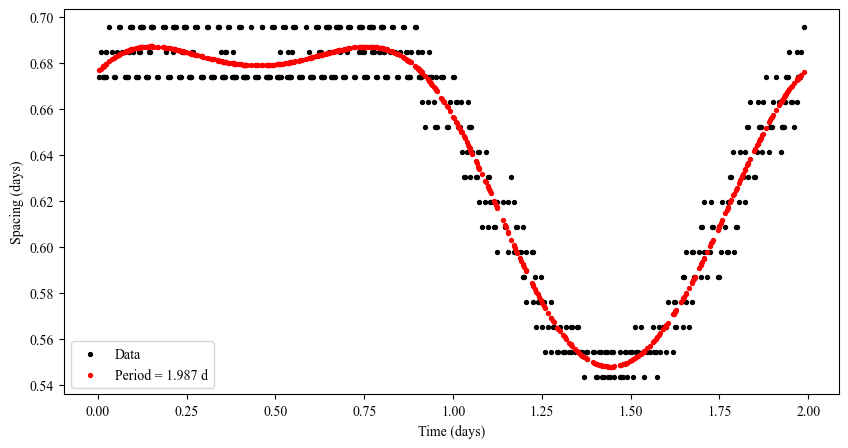

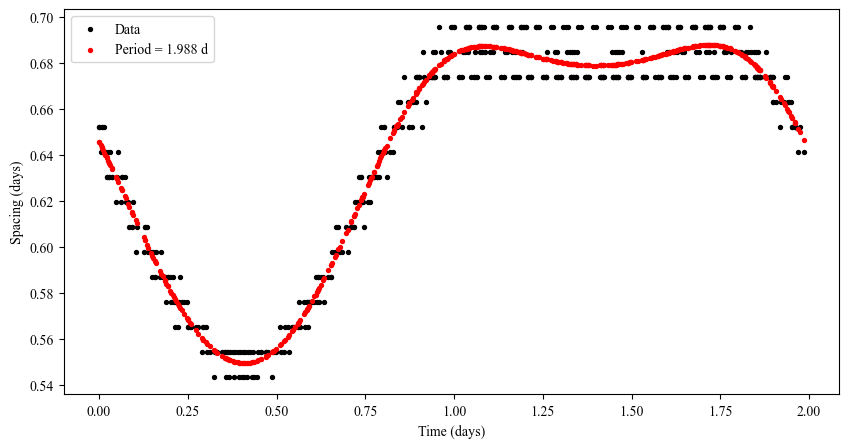

In [193]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(lower_times_N % best_period_N, lower_curve_N, label='Data', color='k', s=8)
plt.scatter(lower_times_N % best_period_N ,pred_N, label=f'Period = {best_period_N:.3f} d', color='r', s=8) # plot the model over the data
plt.xlabel('Time (days)')
plt.ylabel('Spacing (days)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.scatter(lower_times_S % best_period_S, lower_curve_S, label='Data', color='k', s=8)
plt.scatter(lower_times_S % best_period_S, pred_S, label=f'Period = {best_period_S:.3f} d', color='r', s=8) # plot the model over the data
plt.xlabel('Time (days)')
plt.ylabel('Spacing (days)')
plt.legend()
plt.show()


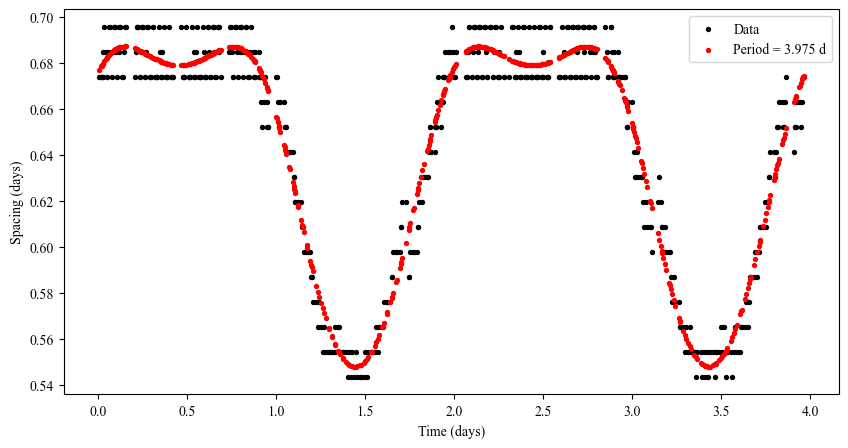

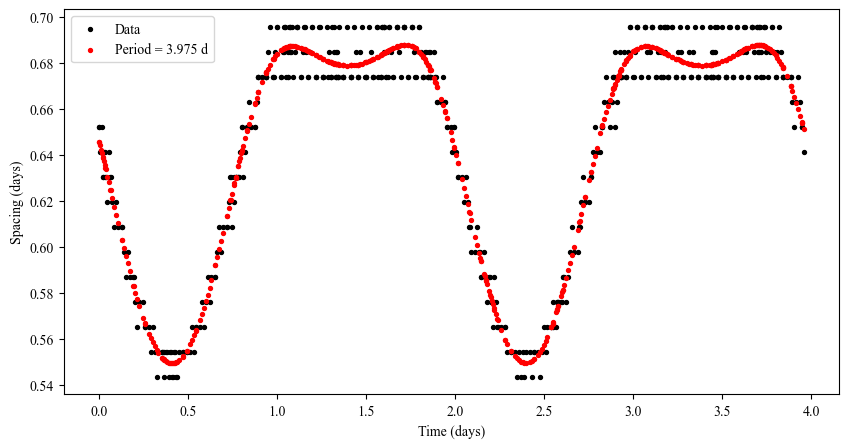

In [192]:
period_N = 2*best_period_N
period_S = 2*best_period_S

fig = plt.figure(figsize=(10, 5))
plt.scatter(lower_times_N % period_N, lower_curve_N, label='Data', color='k', s=8)
plt.scatter(lower_times_N % period_N ,pred_N, label=f'Period = {period_N:.3f} d', color='r', s=8) # plot the model over the data
plt.xlabel('Time (days)')
plt.ylabel('Spacing (days)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.scatter(lower_times_S % period_S, lower_curve_S, label='Data', color='k', s=8)
plt.scatter(lower_times_S % period_S, pred_S, label=f'Period = {period_S:.3f} d', color='r', s=8) # plot the model over the data
plt.xlabel('Time (days)')
plt.ylabel('Spacing (days)')
plt.legend()
plt.show()

In [202]:
synodic = np.abs(1/(1/P_p - 1/P_s))
print('Synodic period %.2f days' % synodic)



Synodic period 11.42 days


In [220]:
# Defining function to automate process 
def LS_periods(M_s, R_s, stellar_periods, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times, planetary_periods):
    visibility_North, visibility_South = ms.maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)*1.0

    synodic_periods = np.abs(1/(1/stellar_periods - 1/planetary_periods))

    if np.count_nonzero(visibility_North) > 0:
        ind_centres_N, ind_durations_N = get_events(times, visibility_North)
        g_centres_N, g_durations_N = group_events(ind_centres_N)
        minima_N = np.where(np.abs(g_centres_N - np.min(g_centres_N)) < 0.01)[0]
        true_durations_N, timings_N = group_events(minima_N)

        xn = g_durations_N 
        yn = (g_centres_N/g_centres_N.max())

        lower_curve_N = [yn[i] for i in range(0, len(yn), 2)]
        lower_times_N = [xn[i] for i in range(0, len(xn), 2)]

        mean_spacing_N = np.mean(np.diff(lower_times_N))

        frequency_N, power_N = LombScargle(lower_times_N, lower_curve_N, nterms=5, normalization='psd').autopower()

        best_frequency_N = frequency_N[np.argmax(power_N)]
        best_period_N = 1/best_frequency_N

        sorted_f_N = np.sort(frequency_N)
        reverse_f_N= sorted_f_N[::-1]

        A1_N = reverse_f_N[0]
        A2_N = reverse_f_N[1]
        A3_N = reverse_f_N[2]

        ratio1_N = A2_N/A1_N
        ratio2_N = A3_N/A1_N
        
    else: 
        mean_spacing_N = np.nan
        best_frequency_N = np.nan
        best_period_N = np.nan
        ratio1_N = np.nan
        ratio2_N = np.nan
    
    if np.count_nonzero(visibility_South) > 0:
        ind_centres_S, ind_durations_S = get_events(times, visibility_South)
        g_centres_S, g_durations_S = group_events(ind_centres_S)
        minima_S = np.where(np.abs(g_centres_S - np.min(g_centres_S)) < 0.01)[0]
        true_durations_S, timings_S = group_events(minima_S)

        xs = g_durations_S
        ys = (g_centres_S/g_centres_S.max())

        lower_curve_S = [ys[i] for i in range(0, len(ys), 2)]
        lower_times_S = [xs[i] for i in range(0, len(xs), 2)]

        mean_spacing_S = np.mean(np.diff(lower_times_S))

        frequency_S, power_S = LombScargle(lower_times_S, lower_curve_S, nterms=5, normalization='psd').autopower()

        best_frequency_S = frequency_S[np.argmax(power_S)]
        best_period_S = 1/best_frequency_S

        sorted_f_S = np.sort(frequency_S)
        reverse_f_S= sorted_f_S[::-1]

        A1_S = reverse_f_S[0]
        A2_S = reverse_f_S[1]
        A3_S = reverse_f_S[2]

        ratio1_S = A2_S/A1_S
        ratio2_S = A3_S/A1_S
    
    else:
        mean_spacing_S = np.nan
        best_frequency_S = np.nan
        best_period_S = np.nan
        ratio1_S = np.nan
        ratio2_S = np.nan
    
    return mean_spacing_N, mean_spacing_S, best_frequency_N, best_frequency_S, best_period_N, best_period_S, ratio1_N, ratio1_S, ratio2_N, ratio2_S, synodic_periods

In [221]:
# Automating the process!

M_s = 0.5 # Star mass (solar masses) #### REFERENCE (PAPER 6 on one note) #####
R_s = 0.75 # Star radius (solar radii) ####  REFERENCE (PAPER 6 on one note) ####
P_s = 4.86 # Star rotation period (days) ####  REFERENCE (PAPER 6 on one note) ####
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) ####  ACCORDING TO MEETING WITH BEN ####
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) #### https://arxiv.org/pdf/2304.09642.pdf #### 
beta = 20 # Star magnetic obliquity (degrees) #### ACCORDING TO MEETING WITH BEN ####
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1) <<<<<< LEFT AS IS
a = 10 # Planet orbital distance (stellar radii) #### REFERENCE (PAPER 6 on one note) ####
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees) #### REFERENCE (PAPER 7 on one note) #### 
lam = 0 # Planet projected spin-orbit angle (degrees) #### ranging from -15 to 18 degrees 
#REFERENCE Spin-orbit alignment and magnetic activity in the young planetary system AU Mic⋆ ####
P_p = 8.4630351 # AU Mic b period in days
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) <<<<< LEFT AS IS
f = 10 # Emission observing frequency (MHz) #### - MAY INCREASE TO 3 GHz REFERENCE (PAPER 6 on one note) ####
alpha = 75 # Emission cone opening angle (degrees) <<<<< LEFT THESE AS IS - BASED ON KAVANAGH 2023
dalpha = 5 # Emission cone thickness (degrees) <<<<< LEFT THESE AS IS - BASED ON KAVANAGH 2023
 

stellar_periods = np.linspace(P_s/2, P_s*2, 100)
planetary_periods = np.linspace(P_p/2, P_p*2, 100)

mean_spacing_grid = np.zeros((len(stellar_periods), len(planetary_periods), 2))
best_frequency_grid = np.zeros((len(stellar_periods), len(planetary_periods), 2))
best_period_grid = np.zeros((len(stellar_periods), len(planetary_periods), 2))
ratio1_grid = np.zeros((len(stellar_periods), len(planetary_periods), 2))
ratio2_grid = np.zeros((len(stellar_periods), len(planetary_periods), 2))
synodic_grid = np.zeros((len(stellar_periods), len(planetary_periods), 1))

for j, s in (enumerate(tqdm(stellar_periods))):
     for k, p in enumerate(planetary_periods):
        mean_spacing_N, mean_spacing_S, best_frequency_N, best_frequency_S, best_period_N, best_period_S, ratio1_N, ratio1_S, ratio2_N, ratio2_S, synodic_periods = LS_periods(M_s, R_s, s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times, p)
        mean_spacing_grid[j, k] = mean_spacing_N, mean_spacing_S
        best_frequency_grid[j, k] = best_frequency_N, best_frequency_S
        best_period_grid[j, k] = best_period_N, best_period_S
        ratio1_grid[j, k] = ratio1_N, ratio1_S
        ratio2_grid[j, k] = ratio2_N, ratio2_S
        synodic_grid[j, k] = synodic_periods




  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [11:51<19:34:12, 711.64s/it]


KeyboardInterrupt: 